In [1]:
!pip install arch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.7 MB/s eta 0:00:00


In [2]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install TA-Lib

--2024-07-04 22:41:57--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-07-04 22:41:57--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-07-04 22:41:57--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Res

In [3]:
pip install tensorflow

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from arch import arch_model
from google.colab import drive
from scipy.interpolate import CubicSpline
drive.mount('/content/drive')

Mounted at /content/drive


In [91]:
#DATA
sp500 = yf.download('^GSPC', start='2007-01-01', end='2024-05-22')
sp500 = sp500[['Close']]
SP500 = sp500.rename(columns={'Close': 'SP500'})

vix = yf.download('^VIX', start='2007-01-01', end='2024-05-22')
vix = vix[['Close']]
vix = vix.rename(columns={'Close': 'VIX'})

vvix = yf.download('^VVIX', start='2007-01-01', end='2024-05-22')
vvix = vvix[['Close']]
vvix = vvix.rename(columns={'Close': 'VVIX'})

gdp = pd.read_csv("/content/drive/MyDrive/gdp_growth.csv", index_col='DATE', parse_dates=True)
unemployment = pd.read_csv("/content/drive/MyDrive/unemployment_rate.csv", index_col='DATE', parse_dates=True)
inflation = pd.read_csv("/content/drive/MyDrive/inflation_rate.csv", index_col='DATE', parse_dates=True)
tbill = pd.read_csv("/content/drive/MyDrive/t_bill_rate.csv", index_col='DATE', parse_dates=True)

daily_index = pd.date_range(start='2007-01-01', end='2024-05-22', freq='D')

SP500 = SP500.reindex(daily_index).interpolate(method='linear', order=3)
vvix = vvix.reindex(daily_index).interpolate(method='linear', order=3)
gdp = gdp.reindex(daily_index).interpolate(method='linear', order=3)
unemployment = unemployment.reindex(daily_index).interpolate(method='linear', order=3)
inflation = inflation.reindex(daily_index).interpolate(method='linear', order=3)
tbill = (tbill.reindex(daily_index).interpolate(method='linear', order=3))

data = SP500.join([gdp, unemployment, inflation, tbill, vvix], how='outer')

data.dropna(inplace=True)

real_option_prices = pd.read_csv("/content/drive/MyDrive/real_option_prices.csv", sep =";",index_col='DATE', parse_dates=True)
real_option_prices = real_option_prices.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
real_option_prices = real_option_prices.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

#TECHNICAL INDICATORS
data['MA20'] = talib.MA(data['SP500'], timeperiod=20)
data['MA50'] = talib.MA(data['SP500'], timeperiod=50)
data['MA200'] = talib.MA(data['SP500'], timeperiod=200)
data['RSI'] = talib.RSI(data['SP500'], timeperiod=14)
macd, macdsignal, macdhist = talib.MACD(data['SP500'], fastperiod=12, slowperiod=26, signalperiod=9)
data['MACD'] = macd
data['MACDSignal'] = macdsignal
data['MACDHist'] = macdhist


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'SP500 Evolution')

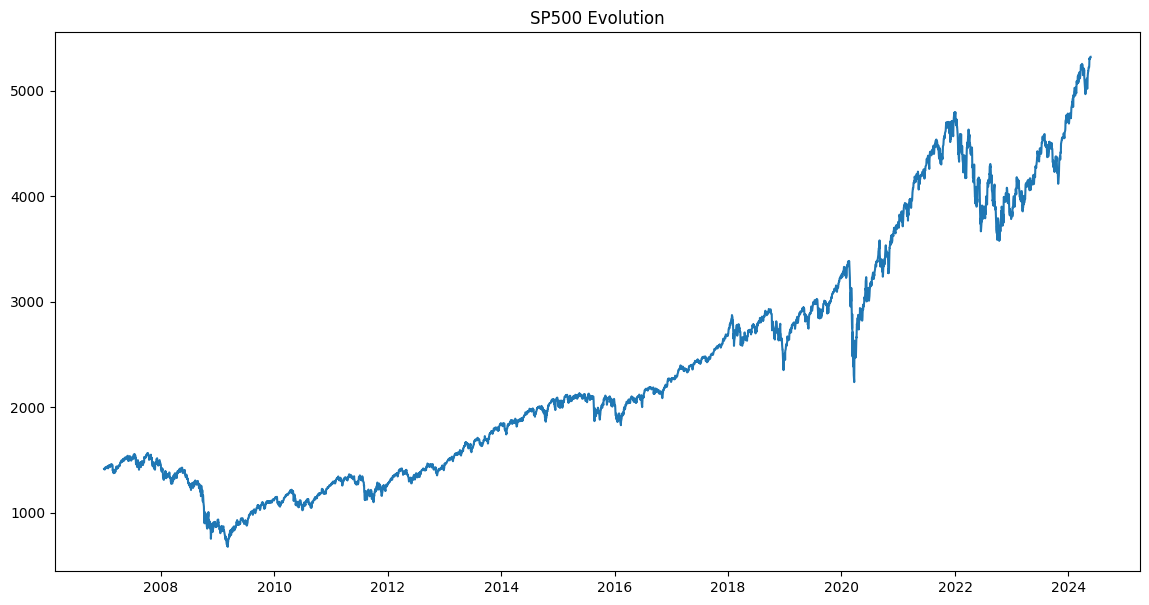

In [92]:
plt.figure(figsize=(14,7))
plt.plot(SP500.index, SP500)
plt.title('SP500 Evolution')

Text(0.5, 1.0, 'VVIX Evolution')

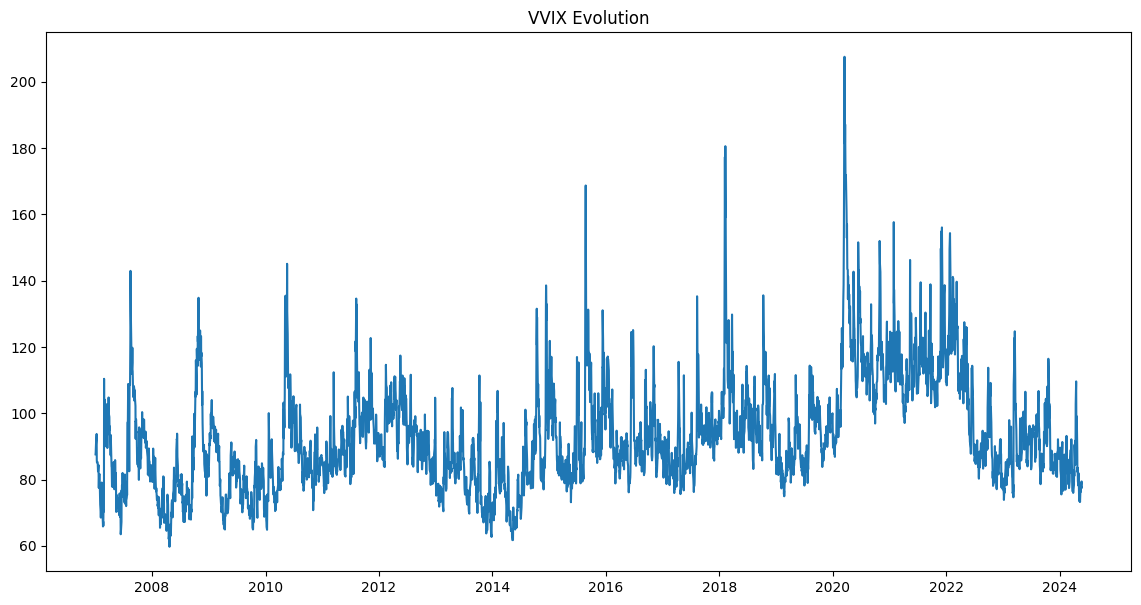

In [93]:
plt.figure(figsize=(14,7))
plt.plot(vvix.index, vvix)
plt.title('VVIX Evolution')

Text(0.5, 1.0, 'GDP Growth Rate')

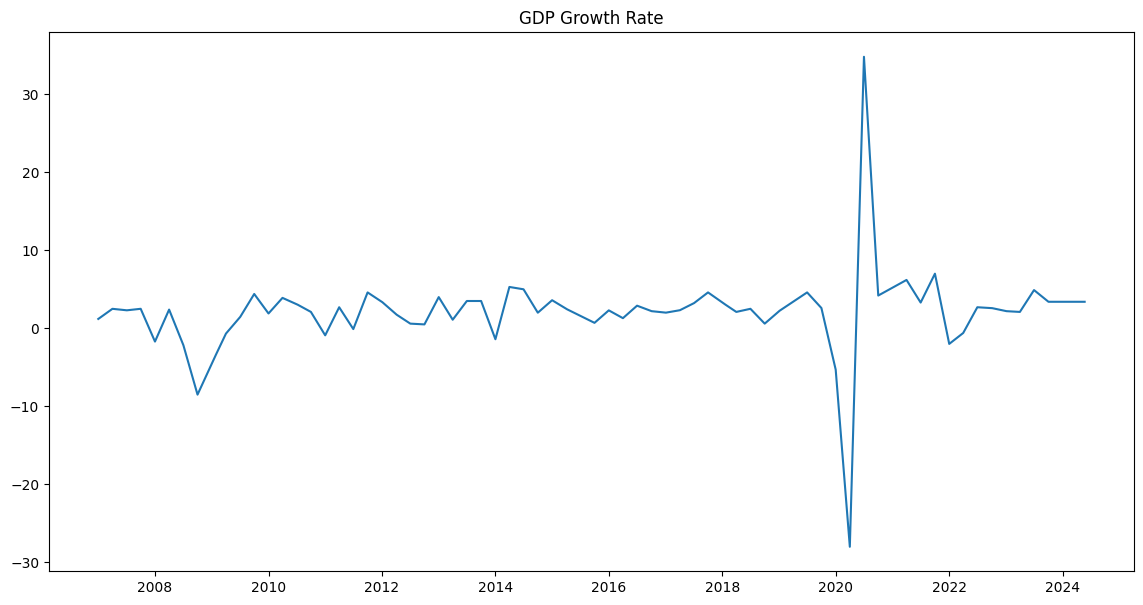

In [94]:
plt.figure(figsize=(14,7))
plt.plot(gdp.index, gdp)
plt.title('GDP Growth Rate')

Text(0.5, 1.0, 'Unemployment Rate')

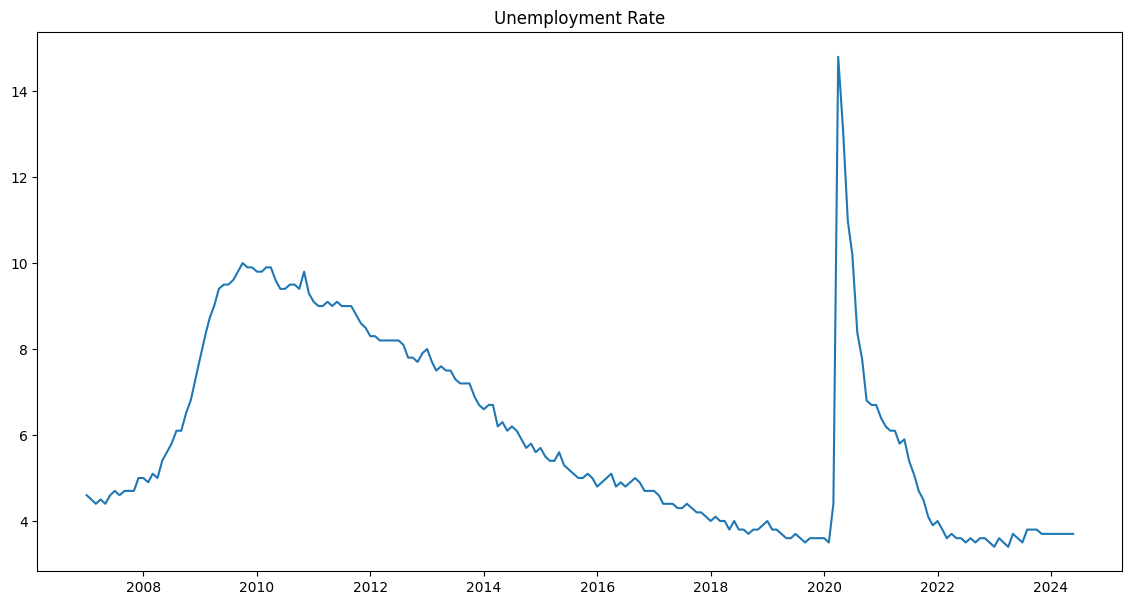

In [95]:
plt.figure(figsize=(14,7))
plt.plot(unemployment.index, unemployment)
plt.title('Unemployment Rate')

Text(0.5, 1.0, 'Inflation Rate')

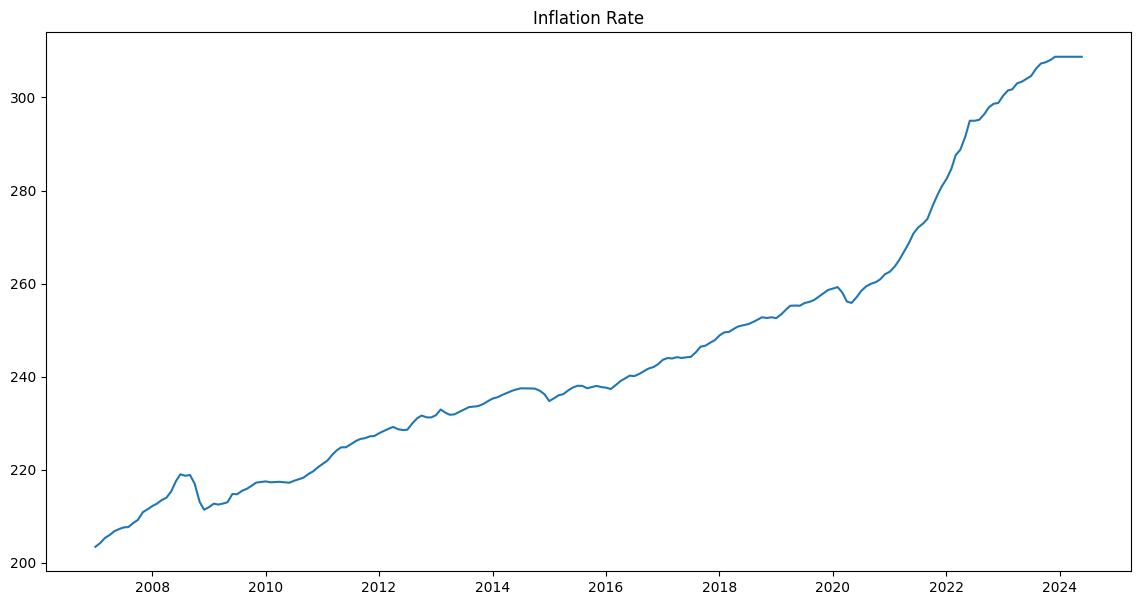

In [96]:
plt.figure(figsize=(14,7))
plt.plot(inflation.index, inflation)
plt.title('Inflation Rate')

Text(0.5, 1.0, 'T-bill Rate')

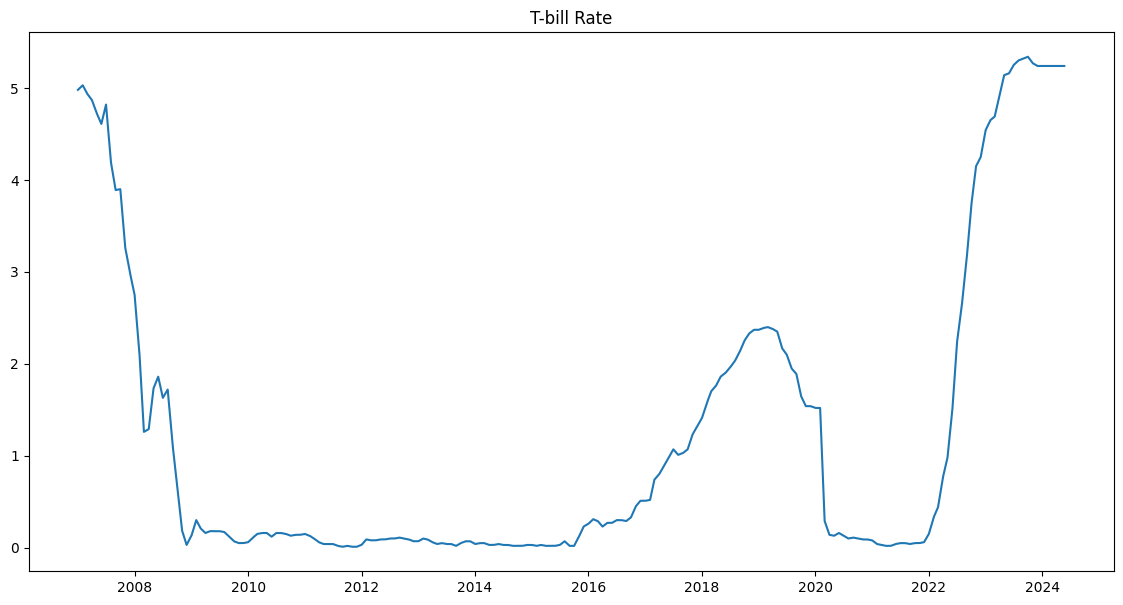

In [97]:
plt.figure(figsize=(14,7))
plt.plot(tbill.index, tbill)
plt.title('T-bill Rate')

## **RANDOM FOREST**

In [98]:
data['log_returns'] = np.log(data['SP500'] / data['SP500'].shift(1))
data['log_returns_scaled'] = data['log_returns'] * 100

#GARCH(1,1) MODEL
model = arch_model(data['log_returns_scaled'].dropna(), vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")
data['garch_vol'] = garch_fit.conditional_volatility
print(data.columns)

#FEATURES
features = ['MA20', 'MA50', 'MA200', 'RSI', 'MACD', 'MACDSignal', 'MACDHist', 'GDP Growth Rate', 'Unemployment Rate', 'Inflation Rate', '3-Month T-Bill Rate', 'VVIX']
X = data[features].fillna(1e-8)
y = data['garch_vol'].fillna(1e-8)

#RANDOM FOREST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# VOLATILIDAD
predicted_volatility = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=['Predicted Volatility'])
predicted_volatility = predicted_volatility.sort_index()
print(predicted_volatility.shape)
print(predicted_volatility.head())

results = pd.DataFrame({'Actual Volatility': y_test, 'Predicted Volatility': predicted_volatility['Predicted Volatility']})
print(results.head())


Index(['SP500', 'GDP Growth Rate', 'Unemployment Rate', 'Inflation Rate',
       '3-Month T-Bill Rate', 'VVIX', 'MA20', 'MA50', 'MA200', 'RSI', 'MACD',
       'MACDSignal', 'MACDHist', 'log_returns', 'log_returns_scaled',
       'garch_vol'],
      dtype='object')
(1270, 1)
            Predicted Volatility
2007-01-11              0.426766
2007-01-17              0.432358
2007-01-18              0.428563
2007-01-20              0.427342
2007-01-22              0.443174
            Actual Volatility  Predicted Volatility
2007-01-11           0.403494              0.426766
2007-01-17           0.410993              0.432358
2007-01-18           0.406962              0.428563
2007-01-20           0.412336              0.427342
2007-01-22           0.410253              0.443174


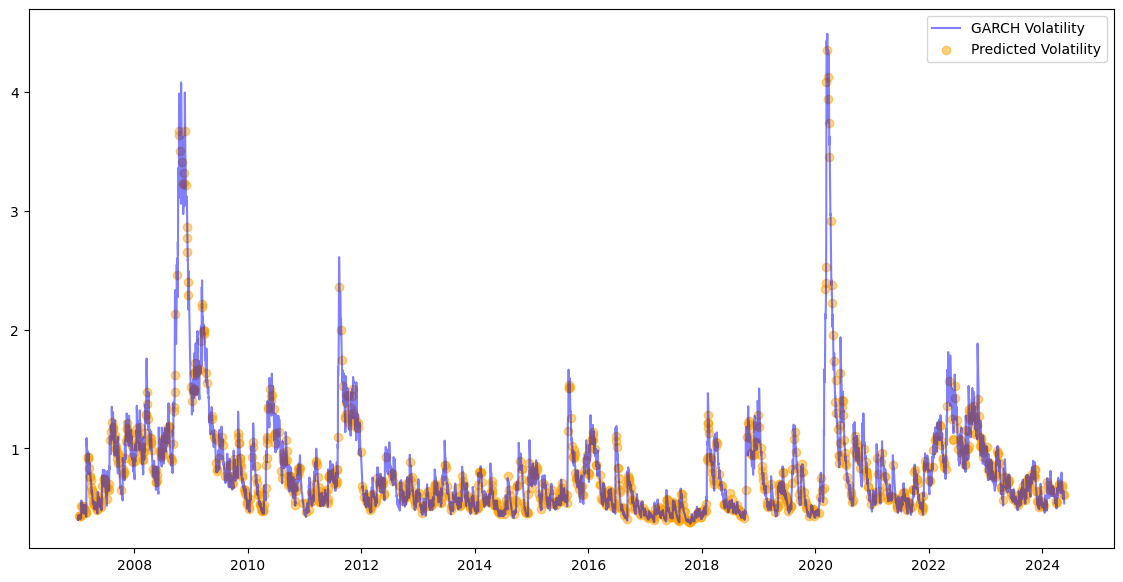

In [99]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['garch_vol'], label='GARCH Volatility', color='blue', alpha=0.5)
plt.scatter(predicted_volatility.index, predicted_volatility['Predicted Volatility'], label='Predicted Volatility', color='orange', alpha=0.5)
plt.legend()
plt.show()

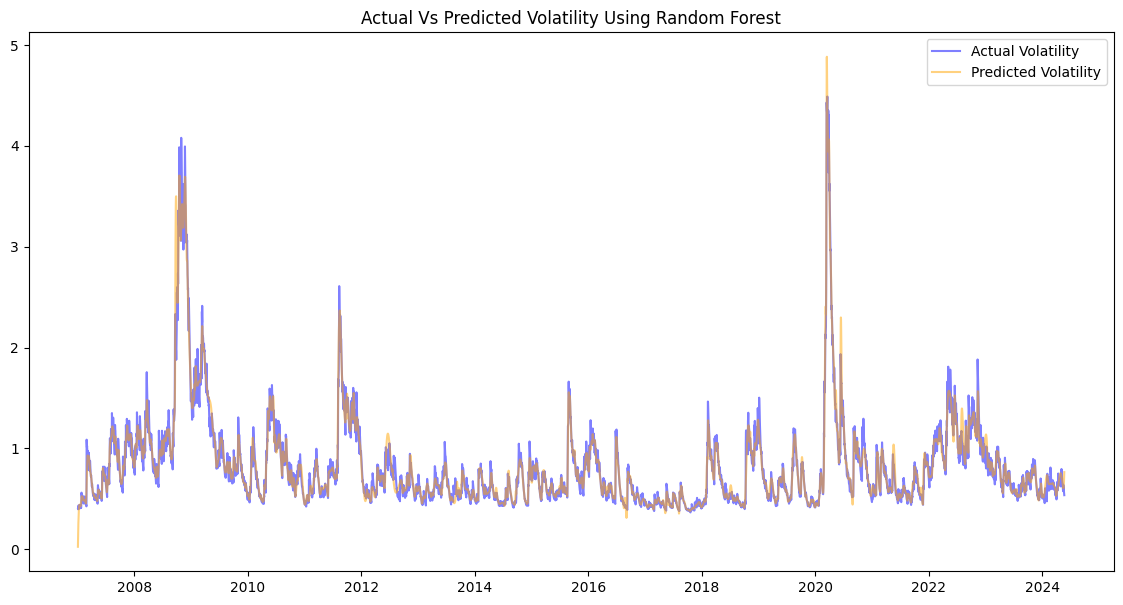

In [100]:
#INTERPOLATED RESULTS
cs = CubicSpline(predicted_volatility.index.to_julian_date(), predicted_volatility['Predicted Volatility'])

data['Interpolated Volatility'] = cs(data.index.to_julian_date())

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['garch_vol'], label='Actual Volatility', color='blue', alpha=0.5)
plt.plot(data.index, data['Interpolated Volatility'], label='Predicted Volatility', color='orange', alpha=0.5)
plt.title('Actual Vs Predicted Volatility Using Random Forest')
plt.legend()
plt.show()

In [101]:
Garch_vol = pd.DataFrame(data['garch_vol'])
filtered_Garch_vol = Garch_vol.loc[Garch_vol.index.intersection(predicted_volatility.index)]


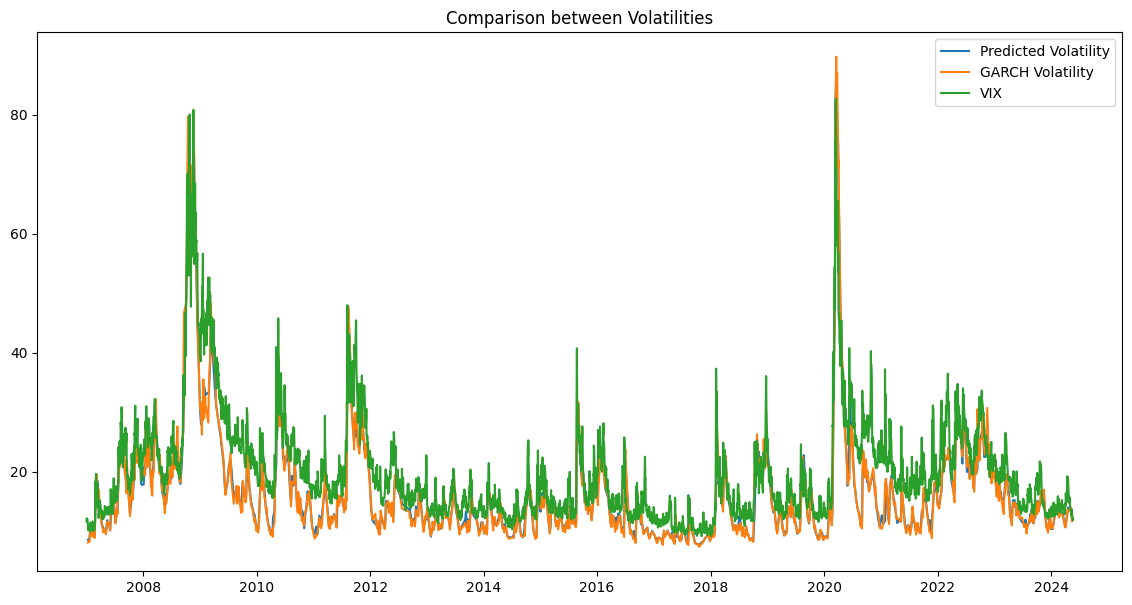

In [102]:
plt.figure(figsize=(14,7))
plt.plot(predicted_volatility*20, label ='Predicted Volatility')
plt.plot(filtered_Garch_vol * 20,label='GARCH Volatility')
plt.plot(vix, label='VIX')
plt.title('Comparison between Volatilities')
plt.legend()

In [103]:
vol = (pd.DataFrame(data['Interpolated Volatility'])*20)/100
filtered_tbill = tbill.loc[tbill.index.intersection(vol.index)]/10

In [104]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    pd.DataFrame(d1)
    d2 = d1 - sigma * np.sqrt(T)
    C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return C

In [105]:
current_prices = pd.DataFrame(data['SP500'][-len(vol):])
strike_prices_97 = current_prices * 0.97
strike_prices_100 = current_prices * 1
strike_prices_103 = current_prices * 1.03

time_to_expiration = np.array([3/12] * len(vol))
time_to_expiration = pd.DataFrame(time_to_expiration, index= data.index, columns=['TTM'])

option_prices_97 = pd.DataFrame(black_scholes(current_prices.values, strike_prices_97.values, time_to_expiration.values, filtered_tbill.values, vol.values),index=data.index, columns=['Option Price Strike 97%'])
option_prices_100 = pd.DataFrame(black_scholes(current_prices.values, strike_prices_100.values, time_to_expiration.values, filtered_tbill.values, vol.values),index=data.index, columns=['Option Price Strike 100%'])
option_prices_103 = pd.DataFrame(black_scholes(current_prices.values, strike_prices_103.values, time_to_expiration.values, filtered_tbill.values, vol.values),index=data.index, columns=['Option Price Strike 103%'])


In [106]:
adjust97 = pd.DataFrame(real_option_prices['Adj 97% RF'])
adjust100 = pd.DataFrame(real_option_prices['Adj 100% RF'])
adjust103 = pd.DataFrame(real_option_prices['Adj 103% RF'])

filtered_tail97 = pd.DataFrame(option_prices_97.loc[option_prices_97.index.intersection(adjust97.index)])
results_97 = pd.DataFrame(filtered_tail97.values / adjust97.values, index= adjust97.index, columns=['Predicted Price Stike 97%'])
filtered_tail100 = pd.DataFrame(option_prices_100.loc[option_prices_100.index.intersection(adjust97.index)])
results_100 = pd.DataFrame(filtered_tail100.values / adjust100.values, index= adjust100.index, columns=['Predicted Price Stike 100%'])
filtered_tail103 = pd.DataFrame(option_prices_103.loc[option_prices_103.index.intersection(adjust97.index)])
results_103 = pd.DataFrame(filtered_tail103.values / adjust103.values, index= adjust103.index, columns=['Predicted Price Stike 103%'])

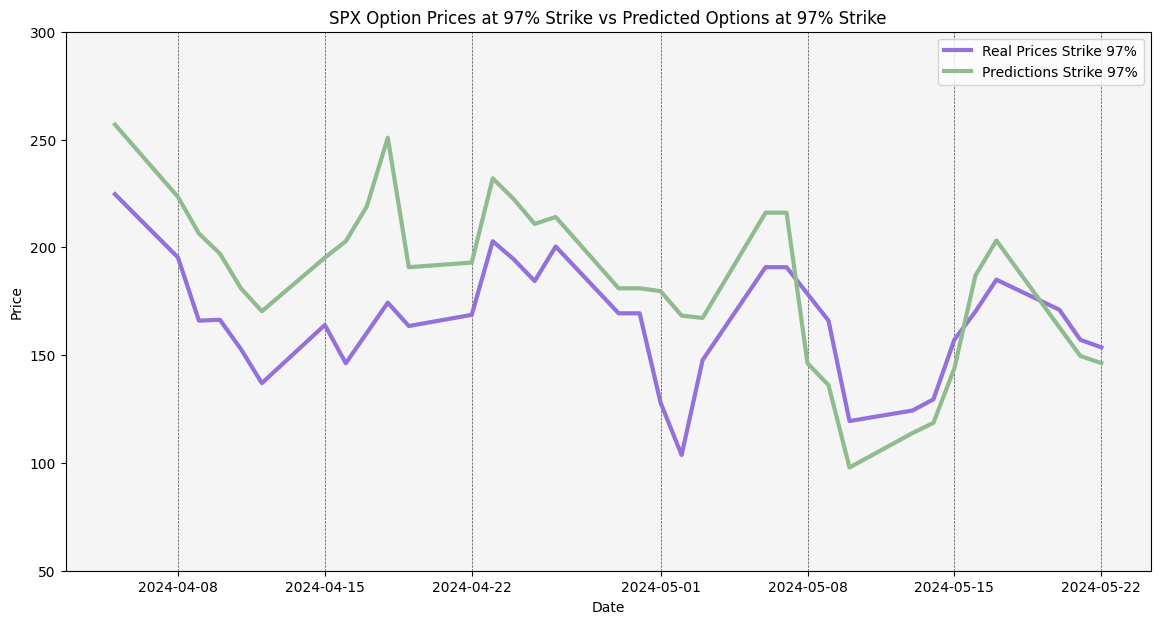

In [107]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('whitesmoke')

ax.plot(real_option_prices['Option Strike 97%'], label='Real Prices Strike 97%',linewidth=3, color = 'mediumpurple')
ax.plot(results_97, label='Predictions Strike 97%', linewidth=3, color = 'darkseagreen')
ax.set_title('SPX Option Prices at 97% Strike vs Predicted Options at 97% Strike')

ax.set_ylim(50, 300)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

ax.grid(True, which='both',axis='x', linestyle='--', linewidth=0.5, color='black', alpha=0.7)


plt.show()

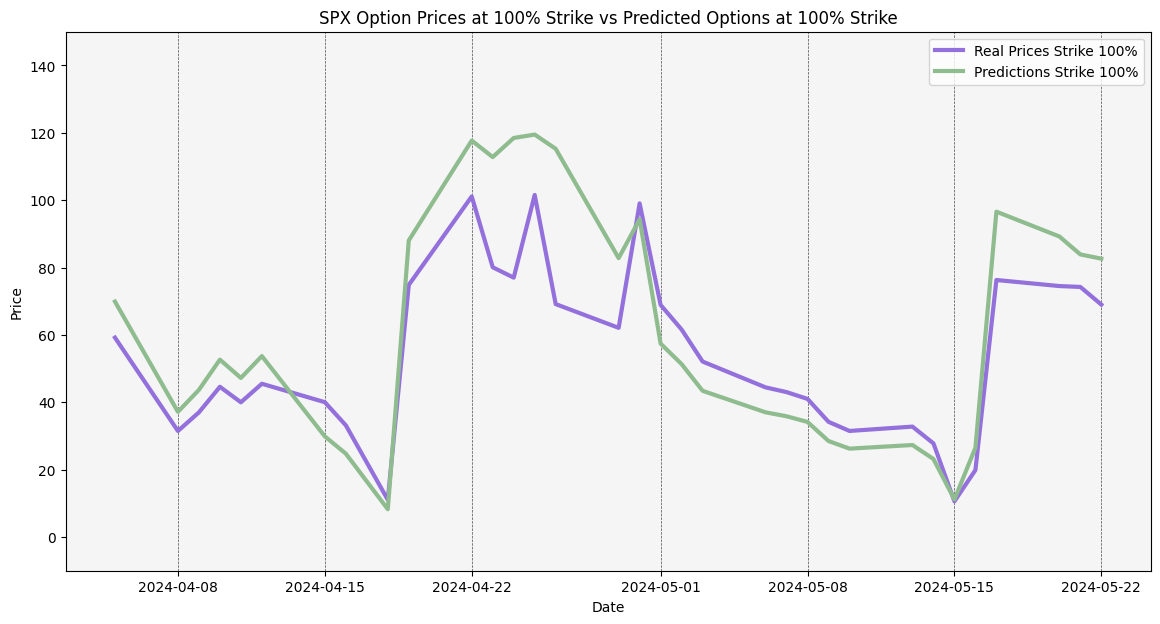

In [108]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('whitesmoke')

ax.plot(real_option_prices['Option Strike 100%'], label='Real Prices Strike 100%',linewidth=3, color = 'mediumpurple')
ax.plot(results_100, label='Predictions Strike 100%', linewidth=3, color = 'darkseagreen')
ax.set_title('SPX Option Prices at 100% Strike vs Predicted Options at 100% Strike')

ax.set_ylim(-10, 150)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

ax.grid(True, which='both',axis='x', linestyle='--', linewidth=0.5, color='black', alpha=0.7)


plt.show()

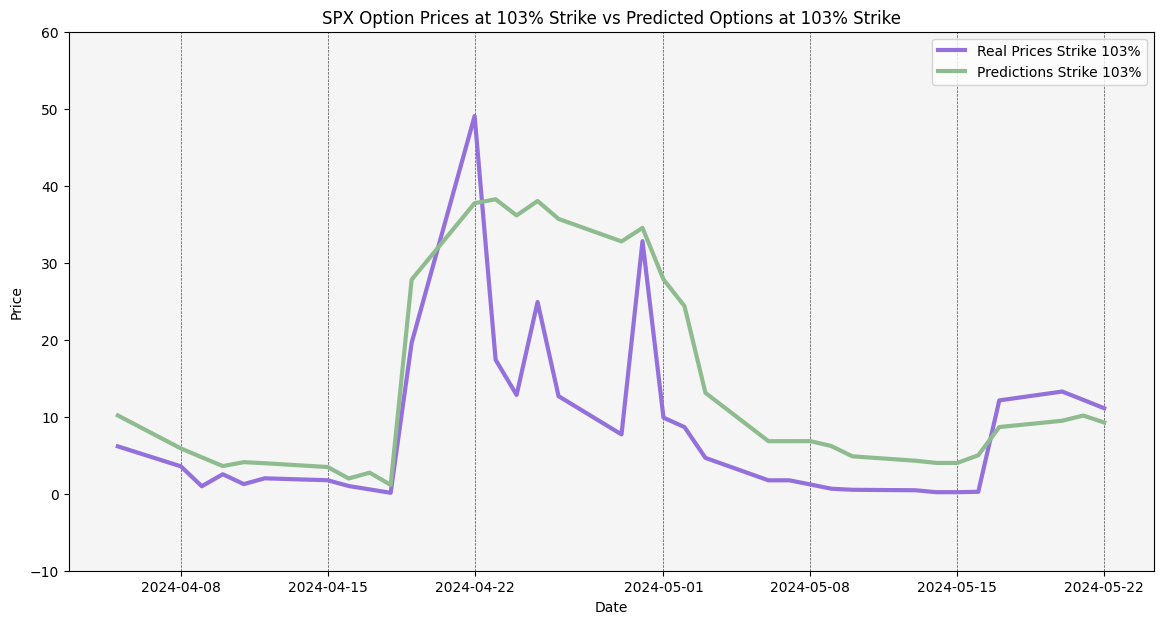

In [109]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('whitesmoke')

ax.plot(real_option_prices['Option Strike 103%'], label='Real Prices Strike 103%',linewidth=3, color = 'mediumpurple')
ax.plot(results_103, label='Predictions Strike 103%', linewidth=3, color = 'darkseagreen')
ax.set_title('SPX Option Prices at 103% Strike vs Predicted Options at 103% Strike')

ax.set_ylim(-10, 60)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

ax.grid(True, which='both',axis='x', linestyle='--', linewidth=0.5, color='black', alpha=0.7)


plt.show()

In [110]:
real_strike97 = pd.DataFrame(real_option_prices['Option Strike 97%'])
real_strike100 = pd.DataFrame(real_option_prices['Option Strike 100%'])
real_strike103 = pd.DataFrame(real_option_prices['Option Strike 103%'])

In [111]:
#Mean Square Error
mse_97 = (pd.DataFrame(real_strike97.values - results_97.values, index=real_strike97.index, columns=['MSE strike 97%']) ** 2).mean()
print("Error Cuadrático Medio (MSE):")
print(mse_97)

mse_100 = (pd.DataFrame(real_strike100.values - results_100.values, index=real_strike100.index, columns=['MSE strike 100%']) ** 2).mean()
print("Error Cuadrático Medio (MSE):")
print(mse_100)

mse_103 = (pd.DataFrame(real_strike103.values - results_103.values, index=real_strike103.index, columns=['MSE strike 103%']) ** 2).mean()
print("Error Cuadrático Medio (MSE):")
print(mse_103)


Error Cuadrático Medio (MSE):
MSE strike 97%    1059.060699
dtype: float64
Error Cuadrático Medio (MSE):
MSE strike 100%    242.748413
dtype: float64
Error Cuadrático Medio (MSE):
MSE strike 103%    101.131302
dtype: float64


In [112]:
#Root Mean Square Error
rmse_97 = np.sqrt(mse_97)
print("Raíz del Error Cuadrático Medio (RMSE):")
print(rmse_97)

rmse_100 = np.sqrt(mse_100)
print("Raíz del Error Cuadrático Medio (RMSE):")
print(rmse_100)

rmse_103 = np.sqrt(mse_103)
print("Raíz del Error Cuadrático Medio (RMSE):")
print(rmse_103)

print("")
mean = pd.DataFrame(np.mean([rmse_97.values, rmse_100.values, rmse_103.values], axis=0),columns=['RMSE'])
print("RMSE Promedio para el modelo Random Forest:")
print(mean)

Raíz del Error Cuadrático Medio (RMSE):
MSE strike 97%    32.543213
dtype: float64
Raíz del Error Cuadrático Medio (RMSE):
MSE strike 100%    15.580386
dtype: float64
Raíz del Error Cuadrático Medio (RMSE):
MSE strike 103%    10.056406
dtype: float64

RMSE Promedio para el modelo Random Forest:
        RMSE
0  19.393335


## **NEURAL NETWORKS**

In [113]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

Epoch 1/50
127/127 [==============================] - 1s 4ms/step - loss: 0.1865 - val_loss: 0.0646
Epoch 2/50
127/127 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0508
Epoch 3/50
127/127 [==============================] - 0s 3ms/step - loss: 0.0689 - val_loss: 0.0453
Epoch 4/50
127/127 [==============================] - 0s 3ms/step - loss: 0.0652 - val_loss: 0.0512
Epoch 5/50
127/127 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0357
Epoch 6/50
127/127 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0347
Epoch 7/50
127/127 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0349
Epoch 8/50
127/127 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0305
Epoch 9/50
127/127 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0300
Epoch 10/50
127/127 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0298

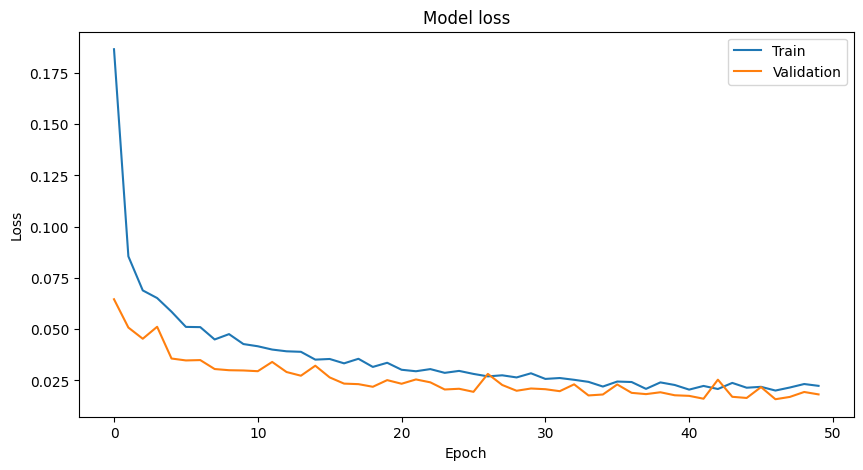

In [114]:
# NORMALIZE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

data_NN = data.iloc[10:]

# NEURAL MODEL
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

#COMPILE MODEL
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# PREDICTING
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# PLOT LOSS VALUES
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [115]:
predictions = model.predict(X_test_scaled).flatten()
results_df = pd.DataFrame({'Actual Volatility': y_test, 'Predicted Volatility': predictions}, index=y_test.index)
df_sorted = results_df.sort_index()

40/40 [==============================] - 0s 979us/step


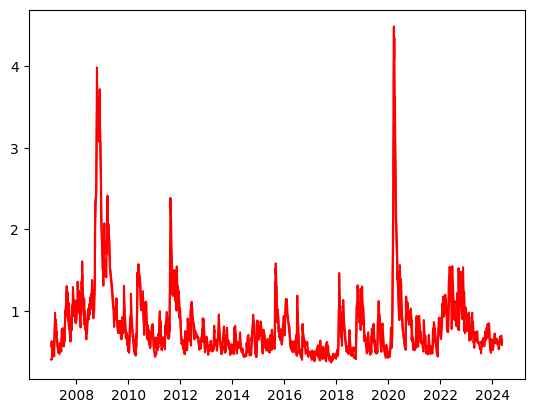

In [116]:
plt.plot(df_sorted, color = 'red')

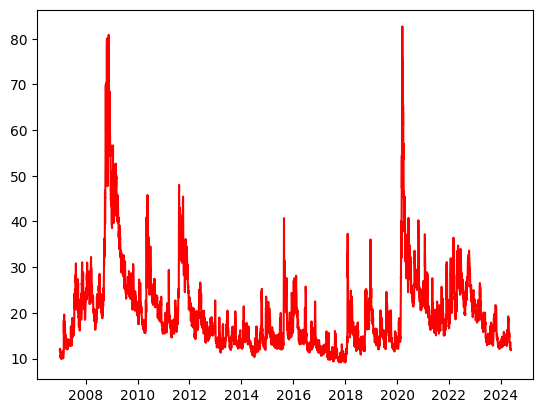

In [117]:
plt.plot(vix, color = 'red', label = 'vix')

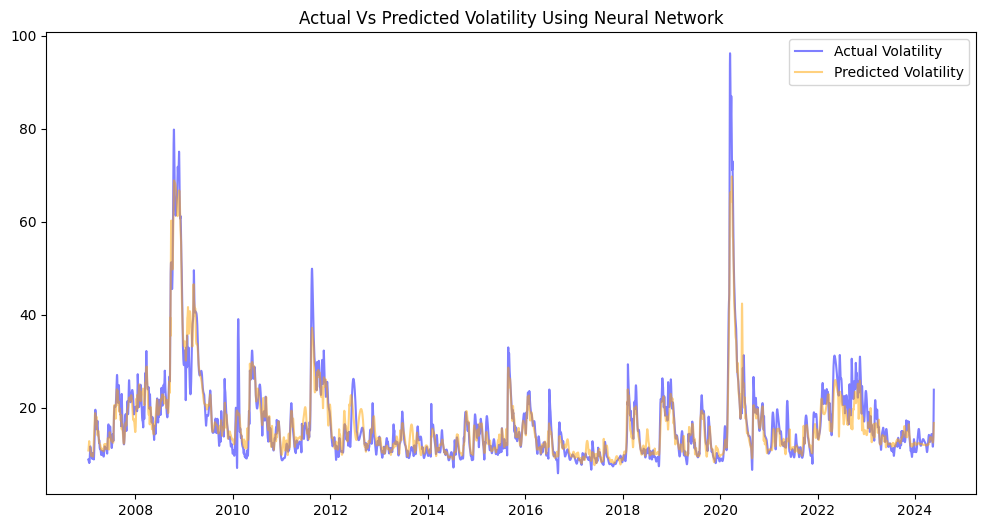

In [118]:
#INTERPOLATION
cs1 = CubicSpline(df_sorted.index, df_sorted['Predicted Volatility'])
cs2 = CubicSpline(df_sorted.index, df_sorted['Actual Volatility'])

data['Interpolated Predicted Volatility NN'] = cs1(data.index)
data['Interpolated Actual Volatility NN'] = cs2(data.index)

Actual_Volatility_NN = pd.DataFrame(data['Interpolated Actual Volatility NN']*20).iloc[10:]
Predicted_Volatility_NN = pd.DataFrame(data['Interpolated Predicted Volatility NN']*20).iloc[10:]

plt.figure(figsize=(12, 6))
plt.plot(data_NN.index, Actual_Volatility_NN, label='Actual Volatility', color='blue', alpha=0.5)
plt.plot(data_NN.index, Predicted_Volatility_NN, label='Predicted Volatility', color='orange', alpha=0.5)
plt.title('Actual Vs Predicted Volatility Using Neural Network')
plt.legend()
plt.show()

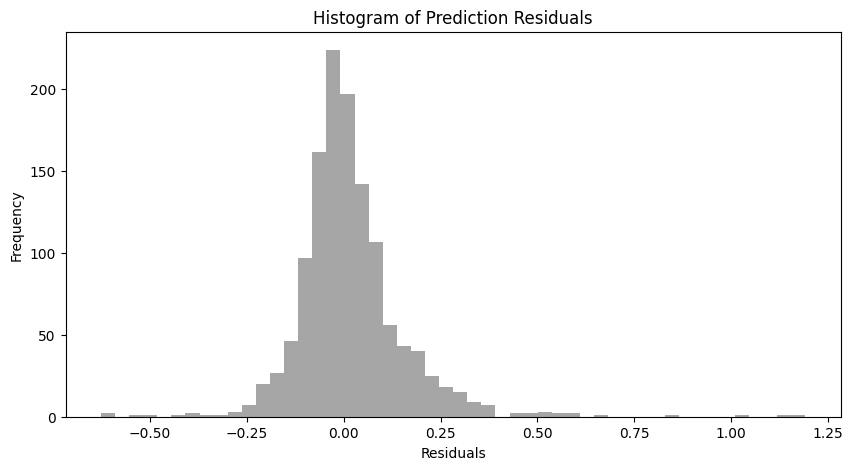

In [119]:
results_df['Residuals'] = results_df['Actual Volatility'] - results_df['Predicted Volatility']

plt.figure(figsize=(10, 5))
plt.hist(results_df['Residuals'], bins=50, color='gray', alpha=0.7)
plt.title('Histogram of Prediction Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [120]:
vol1 = pd.DataFrame(Predicted_Volatility_NN/3)

current_prices_NN = pd.DataFrame(data['SP500'][-len(vol1):])
strike_prices_97_NN = current_prices_NN * 0.97
strike_prices_100_NN = current_prices_NN * 1
strike_prices_103_NN = current_prices_NN * 1.03

time_to_expiration_NN = np.array([3/12] * len(vol1))
time_to_expiration_NN = pd.DataFrame(time_to_expiration, index= data_NN.index, columns=['TTM'])

filtered_tbill_NN = filtered_tbill.iloc[10:]

option_prices_97NN = pd.DataFrame(black_scholes(current_prices_NN.values, strike_prices_97_NN.values, time_to_expiration_NN.values, filtered_tbill_NN.values,  vol1.values),index=data_NN.index, columns=['Option Price Strike 97%'])
option_prices_100NN = pd.DataFrame(black_scholes(current_prices_NN.values, strike_prices_100_NN.values, time_to_expiration_NN.values, filtered_tbill_NN.values,  vol1.values),index=data_NN.index, columns=['Option Price Strike 100%'])
option_prices_103NN = pd.DataFrame(black_scholes(current_prices_NN.values, strike_prices_103_NN.values, time_to_expiration_NN.values, filtered_tbill_NN.values,  vol1.values),index=data_NN.index, columns=['Option Price Strike 103%'])

In [127]:
real_strike97 = pd.DataFrame(real_option_prices['Option Strike 97%'])
real_strike100 = pd.DataFrame(real_option_prices['Option Strike 100%'])
real_strike103 = pd.DataFrame(real_option_prices['Option Strike 103%'])

adjust97NN = pd.DataFrame(real_option_prices['Adj 97% NN'])
adjust100NN = pd.DataFrame(real_option_prices['Adj 100% NN'])
adjust103NN = pd.DataFrame(real_option_prices['Adj 103% NN'])

filtered_tail97NN = pd.DataFrame(option_prices_97NN.loc[option_prices_97NN.index.intersection(real_strike97.index)])
results_97NN = pd.DataFrame(filtered_tail97NN.values / adjust97NN.values, index= adjust97NN.index, columns=['Predicted Price Stike 97%'])
filtered_tail100NN = pd.DataFrame(option_prices_100NN.loc[option_prices_100NN.index.intersection(real_strike100.index)])
results_100NN = pd.DataFrame(filtered_tail100NN.values / adjust100NN.values, index= adjust100NN.index, columns=['Predicted Price Stike 100%'])
filtered_tail103NN = pd.DataFrame(option_prices_103NN.loc[option_prices_103NN.index.intersection(real_strike103.index)])
results_103NN = pd.DataFrame(filtered_tail103NN.values / adjust103NN.values, index= adjust103NN.index, columns=['Predicted Price Stike 103%'])

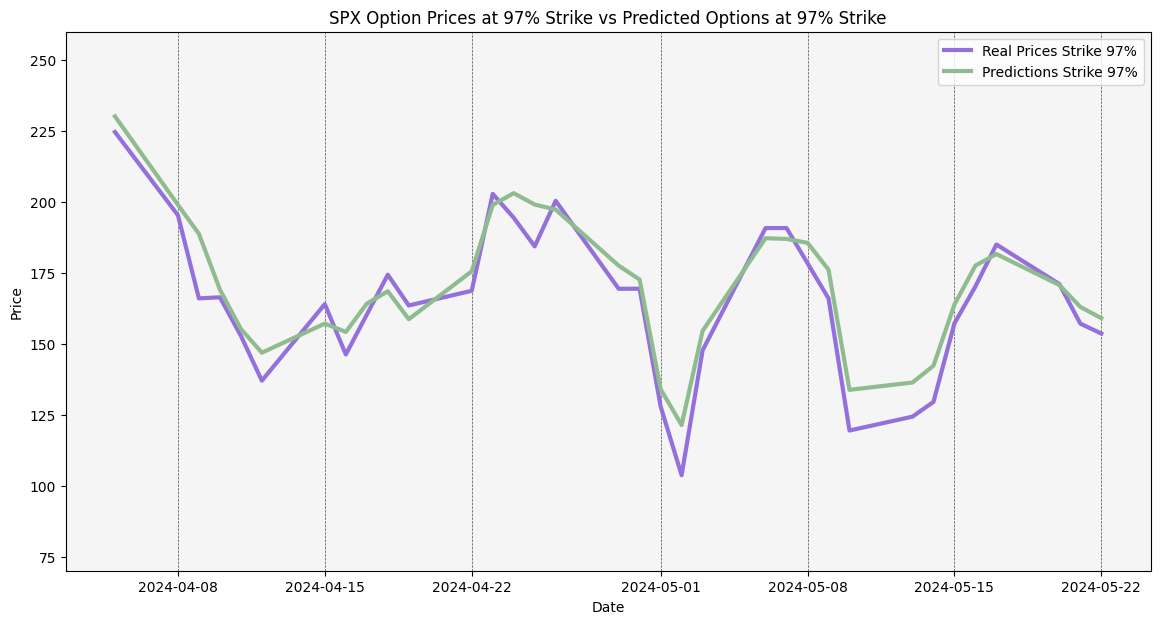

In [128]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('whitesmoke')

ax.plot(real_strike97, label='Real Prices Strike 97%',linewidth=3, color = 'mediumpurple')
ax.plot(results_97NN, label='Predictions Strike 97%', linewidth=3, color = 'darkseagreen')
ax.set_title('SPX Option Prices at 97% Strike vs Predicted Options at 97% Strike')

ax.set_ylim(70, 260)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

ax.grid(True, which='both',axis='x', linestyle='--', linewidth=0.5, color='black', alpha=0.7)


plt.show()

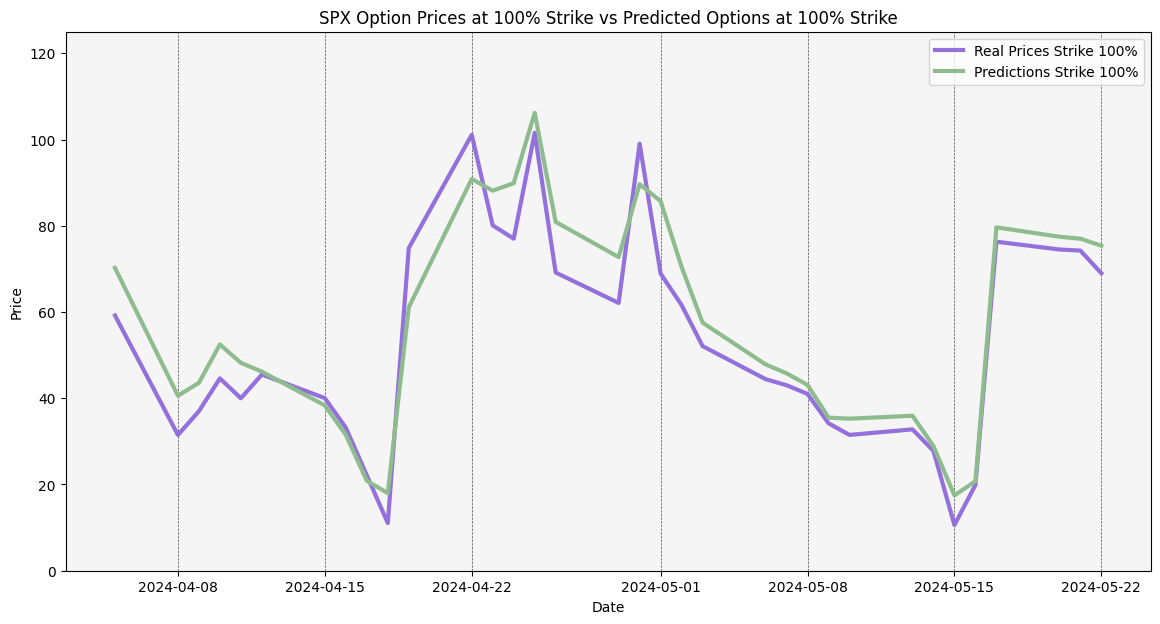

In [129]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('whitesmoke')

ax.plot(real_strike100, label='Real Prices Strike 100%',linewidth=3, color = 'mediumpurple')
ax.plot(results_100NN, label='Predictions Strike 100%', linewidth=3, color = 'darkseagreen')
ax.set_title('SPX Option Prices at 100% Strike vs Predicted Options at 100% Strike')

ax.set_ylim(0, 125)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

ax.grid(True, which='both',axis='x', linestyle='--', linewidth=0.5, color='black', alpha=0.7)


plt.show()

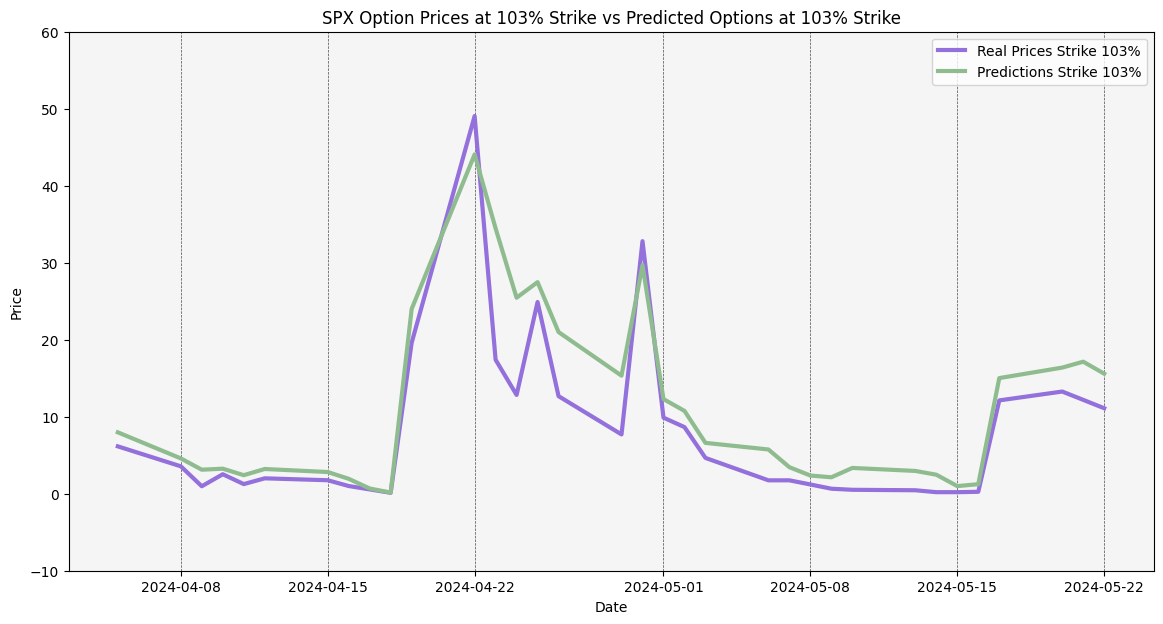

In [130]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('whitesmoke')

ax.plot(real_strike103, label='Real Prices Strike 103%',linewidth=3, color = 'mediumpurple')
ax.plot(results_103NN, label='Predictions Strike 103%', linewidth=3, color = 'darkseagreen')
ax.set_title('SPX Option Prices at 103% Strike vs Predicted Options at 103% Strike')

ax.set_ylim(-10, 60)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

ax.grid(True, which='both',axis='x', linestyle='--', linewidth=0.5, color='black', alpha=0.7)


plt.show()

In [131]:
#Mean Square Error
mse_97NN = (pd.DataFrame(real_strike97.values - results_97NN.values, index=real_strike97.index, columns=['MSE strike 97%']) ** 2).mean()
print("Error Cuadrático Medio (MSE):")
print(mse_97NN)

mse_100NN = (pd.DataFrame(real_strike100.values - results_100NN.values, index=real_strike100.index, columns=['MSE strike 100%']) ** 2).mean()
print("Error Cuadrático Medio (MSE):")
print(mse_100NN)

mse_103NN = (pd.DataFrame(real_strike103.values - results_103NN.values, index=real_strike103.index, columns=['MSE strike 103%']) ** 2).mean()
print("Error Cuadrático Medio (MSE):")
print(mse_103NN)

Error Cuadrático Medio (MSE):
MSE strike 97%    75.244114
dtype: float64
Error Cuadrático Medio (MSE):
MSE strike 100%    55.16522
dtype: float64
Error Cuadrático Medio (MSE):
MSE strike 103%    22.744465
dtype: float64


In [132]:
#Root Mean Square Error
rmse_97NN = np.sqrt(mse_97NN)
print("Raíz del Error Cuadrático Medio (RMSE):")
print(rmse_97NN)

rmse_100NN = np.sqrt(mse_100NN)
print("Raíz del Error Cuadrático Medio (RMSE):")
print(rmse_100NN)

rmse_103NN = np.sqrt(mse_103NN)
print("Raíz del Error Cuadrático Medio (RMSE):")
print(rmse_103NN)

print("")
mean = pd.DataFrame(np.mean([rmse_97NN.values, rmse_100NN.values, rmse_103NN.values], axis=0),columns=['RMSE'])
print("RMSE Promedio para el modelo Random Forest")
print(mean)

Raíz del Error Cuadrático Medio (RMSE):
MSE strike 97%    8.674336
dtype: float64
Raíz del Error Cuadrático Medio (RMSE):
MSE strike 100%    7.427329
dtype: float64
Raíz del Error Cuadrático Medio (RMSE):
MSE strike 103%    4.769116
dtype: float64

RMSE Promedio para el modelo Random Forest
       RMSE
0  6.956927
